# Ensemble-Additive Model: Heart Disease Predictors

[Data Set Source](https://www.kaggle.com/ronitf/heart-disease-uci)   

## Imports

In [1]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
from sklearn import preprocessing

## Loading Data
#### 310 Observations, 13 Attributes (12 Numeric Predictors, 1 Binary Class Attribute - No Demographics)

In [2]:
df = pd.read_csv("/Users/zorazhang/Desktop/heartUCI.csv")
df = shuffle(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
104,50,1,2,129,196,0,1,163,0,0.0,2,0,2,1
98,43,1,2,130,315,0,1,162,0,1.9,2,1,2,1
237,60,1,0,140,293,0,0,170,0,1.2,1,2,3,0
135,49,0,0,130,269,0,1,163,0,0.0,2,0,2,1
16,58,0,2,120,340,0,1,172,0,0.0,2,0,2,1


#### Normalization

In [3]:
min_max_scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df))
df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

## Net
#### Each net has 2 hidden layers, each layer has 300 nodes, M = 5

In [4]:
class Net(nn.Module):
    def __init__(self, layerWidth=300):
        super(Net, self).__init__();
        self.fc1 = nn.Linear(1, layerWidth)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(layerWidth, layerWidth)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(layerWidth, layerWidth)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.fc4 = nn.Linear(layerWidth,1)
        nn.init.kaiming_normal_(self.fc4.weight)
    def forward (self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#### Create a 2D neural networks array: nets

In [5]:
nets = []
for i in range(5):
    subnets = []
    for i in range(len(df.columns)):
        subnets.append( Net() )
    nets.append(subnets)

In [6]:
for net in nets:
    for subnet in net:
        with torch.no_grad():
            subnet.state_dict()['fc4.weight'] /= 10

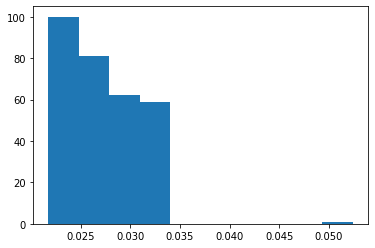

In [8]:
allInput = np.array(df['chol'])
tensorAllInput = torch.from_numpy(allInput).float().reshape(-1,1)
tensorAllOut = nets[0][0](tensorAllInput)
allOut = tensorAllOut.detach().numpy()
plt.hist(allOut)
plt.show()

## Minibatch
#### 5 batches, each contains 50 rows

In [9]:
batches = []
for i in range (5):
    batch = df.sample(n = 20,replace = True)
    batches.append(batch)

#### Split each batch into Inputs and Targets

In [11]:
# 5 groups of 12-column inputs
inputs = []
# 5 groups of 1-column target
targets = []
# All the column names
titles = []
for i in range(len(batches)):
    titles = np.array((batches[i].columns))
    inputs.append(batches[i].iloc[:, 0:len(df.columns) - 1])
    targets.append(batches[i]['target'])
print(inputs[1].shape)
titles = titles[:-1]
print(titles)

(20, 13)
['age' 'sex' 'cp' 'trestbps' 'chol' 'fbs' 'restecg' 'thalach' 'exang'
 'oldpeak' 'slope' 'ca' 'thal']


#### Organize inputs into a torch tensor: In

In [12]:
In = []
for index in range(len(inputs)):
    subIn = []
    for i, feature in enumerate(titles):
        columnInput = torch.from_numpy(np.array(inputs[index][feature])).float().reshape(-1,1)
        subIn.append(columnInput)
    In.append(subIn)

# Usage format: 
# print(In[0][11])
# 0 denotes the batch index, 11 denotes the feature index

#### Organize targets into a torch tensor: Target

In [13]:
Target = []
for index in range (len(targets)):
    columnTarget = torch.from_numpy(np.array(targets[index])).float().reshape(-1,1)
    Target.append(columnTarget)

# Usage format:
# print(Target[0])
# 0 denotes the batch index

## Training

In [14]:
for i, net in enumerate(nets):
    
    netTarget = Target[i]
    netInput = In[i] 
        
    optimizers = [optim.Adam(net[i].parameters()) for i in range(len(net))]
    criterion = nn.MSELoss()
    epochs = tqdm_notebook(range(500))

    for epoch in epochs:

        for optimizer in optimizers:
            optimizer.zero_grad()

        Out = [net[i](netInput[i]) for i in range(len(net) - 1)]
        totalOut = sum(Out)
        totalOut = torch.sigmoid(totalOut)
        loss = criterion(totalOut, netTarget)
        loss.backward()

        for optimizer in optimizers:
            optimizer.step()

        epochs.set_description(str(loss.data.item()))

## Plotting

#### Each net's performance on different symptoms

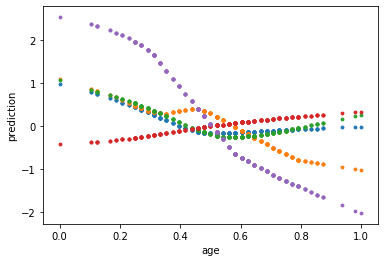

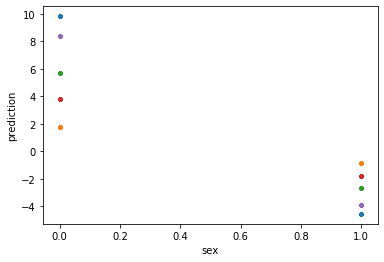

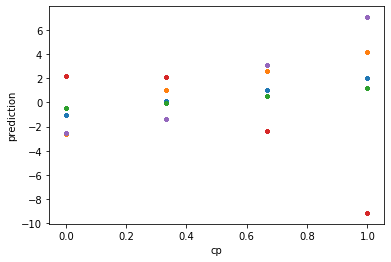

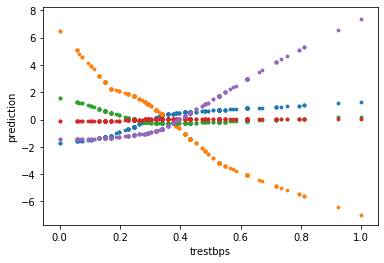

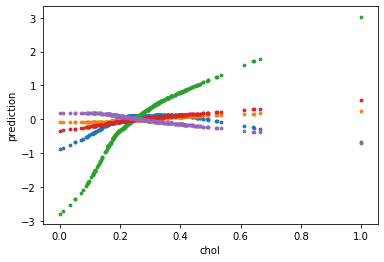

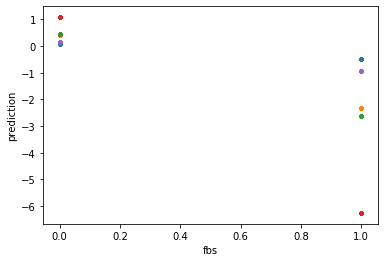

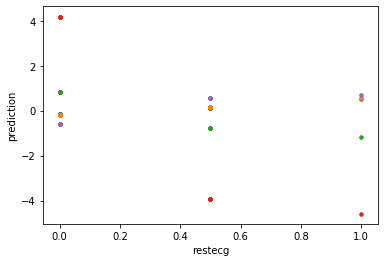

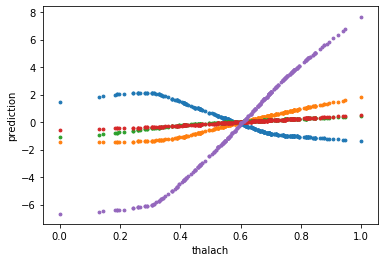

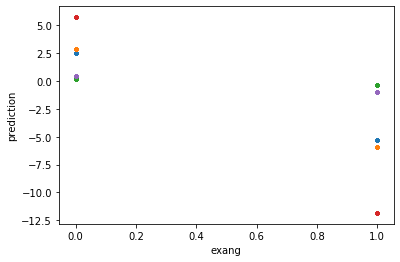

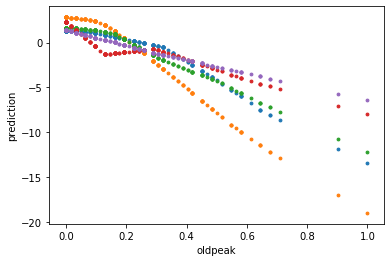

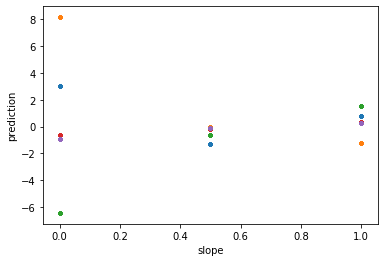

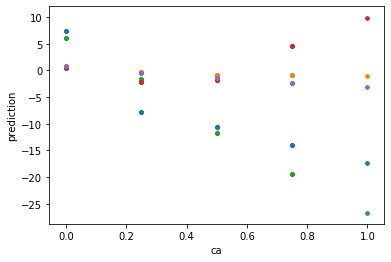

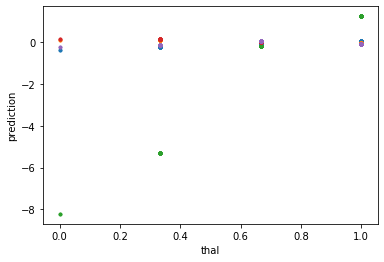

[4.753399081528187, 1.5714802592992783, 6.774259980767965, 3.4164502322673798, -0.7394662275910378]


In [18]:
offset = [0] * 5
for i, feature in enumerate(titles):
    for n in range (5):
        mynet = nets[n]
        allInput = np.array(df[feature])
        tensorAllInput = torch.from_numpy(allInput).float().reshape(-1,1)
        tensorAllOut = mynet[i](tensorAllInput)
        allOut = tensorAllOut.detach().numpy()
        
        meanOut = np.mean(allOut)
        newOut = allOut - meanOut
        offset[n] = offset[n] + meanOut
        
        plt.scatter(allInput, newOut, s = 8)
        plt.xlabel(feature)
        plt.ylabel('prediction')
    plt.show()
print(offset)

In [ ]:
for i, feature in enumerate(titles):
    meanOut = []
    sds = []
    
    for n in range (5):
        mynet = nets[n]
        allInput = np.array(df[feature])
        tensorAllInput = torch.from_numpy(allInput).float().reshape(-1,1)
        tensorAllOut = mynet[i](tensorAllInput)
        allOut = tensorAllOut.detach().numpy()
        print(allOut.shape)
        
        for k in range(len(allOut)):
            meanOut.append(allOut)
    mean = np.mean(np.array(meanOut))
    sds.append(np.std(meanOut))
    plt.errorbar(allInput, mean, yerr = sds, ecolor = 'lightblue')
    plt.xlabel(feature)
    plt.ylabel('prediction')
    plt.show()